## Studi Analisis Empiris dan PCA terhadap Dataset Penyakit Kronis Menggunakan KNN

Studi ini bertujuan untuk:
1. Menganalisis dataset penyakit kronis secara empiris.
2. Menerapkan Principal Component Analysis (PCA) untuk mereduksi dimensi data.
3. Membandingkan performa model K-Nearest Neighbors (KNN) sebelum dan sesudah PCA.

Menggunakan dataset berisi informasi pasien dengan fitur Usia, Jenis Kelamin, Tekanan Darah, BMI, Gula Darah, Kolesterol, Merokok, Riwayat Keluarga, dan target Penyakit Kronis (Multi-kelas)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set seed untuk reproduksibilitas
np.random.seed(42)

In [4]:
# Load dataset
patient_df = pd.read_excel("DATA JANTUNG RM(3).xlsx")
diabetes_df = pd.read_csv("diabetes.csv")
heart_df = pd.read_csv("heart.csv")

In [5]:
# Tampilkan kolom untuk verifikasi
print("Kolom dalam diabetes_df:", diabetes_df.columns)
print("Kolom dalam heart_df:", heart_df.columns)
print("Kolom dalam patient_df:", patient_df.columns)

Kolom dalam diabetes_df: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Kolom dalam heart_df: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
Kolom dalam patient_df: Index(['NO', 'NO.RM', 'NOPEN', 'NAMA PASIEN', 'JK', 'Tanggal lahir', 'Usia',
       'Tanggal Registrasi', 'Unit pelayanan', 'Dokter', 'Tanggal keluar',
       'Ruang Akhir', 'Diagnosa/icd 10', 'Glukosa', 'Ureum', 'Kreatinin',
       'SGOT', 'SGPT', 'Tekanan darah', 'Penglihatan', 'Pendengaran',
       'Penciuman', 'Bicara', 'Pernafasan'],
      dtype='object')


In [6]:
# Dataset 1: Diabetes
diabetes_df = diabetes_df[['Age', 'Glucose', 'BloodPressure', 'BMI', 'Outcome']]
diabetes_df.columns = ['age', 'glucose', 'bp_systolic', 'bmi', 'target']
diabetes_df['sex'] = np.where(diabetes_df['age'] >= 21, 0, 1)  # Asumsi sederhana

# Dataset 2: Heart Disease
heart_df = heart_df[['age', 'sex', 'trestbps', 'chol', 'target']]
heart_df.columns = ['age', 'sex', 'bp_systolic', 'cholesterol', 'target']
heart_df['glucose'] = heart_df['cholesterol'] * 0.1  # Estimasi glucose
heart_df['bmi'] = heart_df['cholesterol'] * 0.05  # Estimasi BMI sederhana

# Dataset 3: Patient Records
patient_df['sex'] = patient_df['JK'].map({'L': 1, 'P': 0})
patient_df['bp_systolic'] = pd.to_numeric(
    patient_df['Tekanan darah'].str.split('/').str[0], errors='coerce'
)
patient_df['target'] = patient_df['Diagnosa/icd 10'].apply(lambda x: 1 if isinstance(x, str) and 'I' in x else 0)
patient_df = patient_df[['Usia', 'sex', 'Glukosa', 'bp_systolic', 'target']]
patient_df.columns = ['age', 'sex', 'glucose', 'bp_systolic', 'target']
patient_df['bmi'] = patient_df['bp_systolic'] * 0.02  # Estimasi BMI sederhana

In [7]:
# Gabungkan dataset
combined_df = pd.concat([
    diabetes_df[['age', 'sex', 'glucose', 'bp_systolic', 'bmi', 'target']],
    heart_df[['age', 'sex', 'glucose', 'bp_systolic', 'cholesterol', 'target']],
    patient_df[['age', 'sex', 'glucose', 'bp_systolic', 'bmi', 'target']]
], ignore_index=True)

In [8]:
# --- Pembersihan Data Sebelum Imputasi ---
# Konversi semua kolom ke string terlebih dahulu untuk menangani spasi kosong
for col in ['age', 'sex', 'glucose', 'bp_systolic', 'bmi']:
    combined_df[col] = combined_df[col].astype(str).str.strip()
    # Ganti spasi kosong atau string kosong dengan NaN
    combined_df[col] = combined_df[col].replace('', np.nan)
    combined_df[col] = combined_df[col].replace(' ', np.nan)
    # Konversi ke numerik
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Inspeksi data sebelum imputasi
print("\n=== Inspeksi Data Sebelum Imputasi ===")
print("Tipe data kolom:\n", combined_df.dtypes)
print("Jumlah nilai hilang per kolom:\n", combined_df.isnull().sum())

# --- Imputasi Nilai Hilang ---
imputer = SimpleImputer(strategy='median')
combined_df[['age', 'sex', 'glucose', 'bp_systolic', 'bmi']] = imputer.fit_transform(
    combined_df[['age', 'sex', 'glucose', 'bp_systolic', 'bmi']]
)

# Pastikan semua kolom numerik setelah imputasi
for col in ['age', 'sex', 'glucose', 'bp_systolic', 'bmi']:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Inspeksi data setelah imputasi
print("\n=== Inspeksi Data Setelah Imputasi ===")
print("Tipe data kolom:\n", combined_df.dtypes)
print("Jumlah nilai hilang per kolom:\n", combined_df.isnull().sum())


=== Inspeksi Data Sebelum Imputasi ===
Tipe data kolom:
 age            float64
sex              int64
glucose        float64
bp_systolic    float64
bmi            float64
target           int64
cholesterol    float64
dtype: object
Jumlah nilai hilang per kolom:
 age               1
sex               0
glucose           0
bp_systolic       1
bmi            1026
target            0
cholesterol    1408
dtype: int64

=== Inspeksi Data Setelah Imputasi ===
Tipe data kolom:
 age            float64
sex            float64
glucose        float64
bp_systolic    float64
bmi            float64
target           int64
cholesterol    float64
dtype: object
Jumlah nilai hilang per kolom:
 age               0
sex               0
glucose           0
bp_systolic       0
bmi               0
target            0
cholesterol    1408
dtype: int64



=== Analisis Empiris ===



Statistik Deskriptif:
                age          sex      glucose  bp_systolic          bmi  \
count  2433.000000  2433.000000  2433.000000  2433.000000  2433.000000   
mean     48.537608     0.422935    88.172215   115.880588    20.611488   
std      15.382738     0.494127    61.756604    38.762603    12.053248   
min       2.000000     0.000000     0.000000     0.000000     0.000000   
25%      37.000000     0.000000    25.200000    82.000000     3.800000   
50%      51.000000     0.000000    96.000000   120.000000    23.100000   
75%      60.000000     1.000000   134.000000   140.000000    26.100000   
max      93.000000     1.000000   290.000000   267.000000    67.100000   

            target  cholesterol  
count  2433.000000   1025.00000  
mean      0.578298    246.00000  
std       0.493933     51.59251  
min       0.000000    126.00000  
25%       0.000000    211.00000  
50%       1.000000    240.00000  
75%       1.000000    275.00000  
max       1.000000    564.00000  


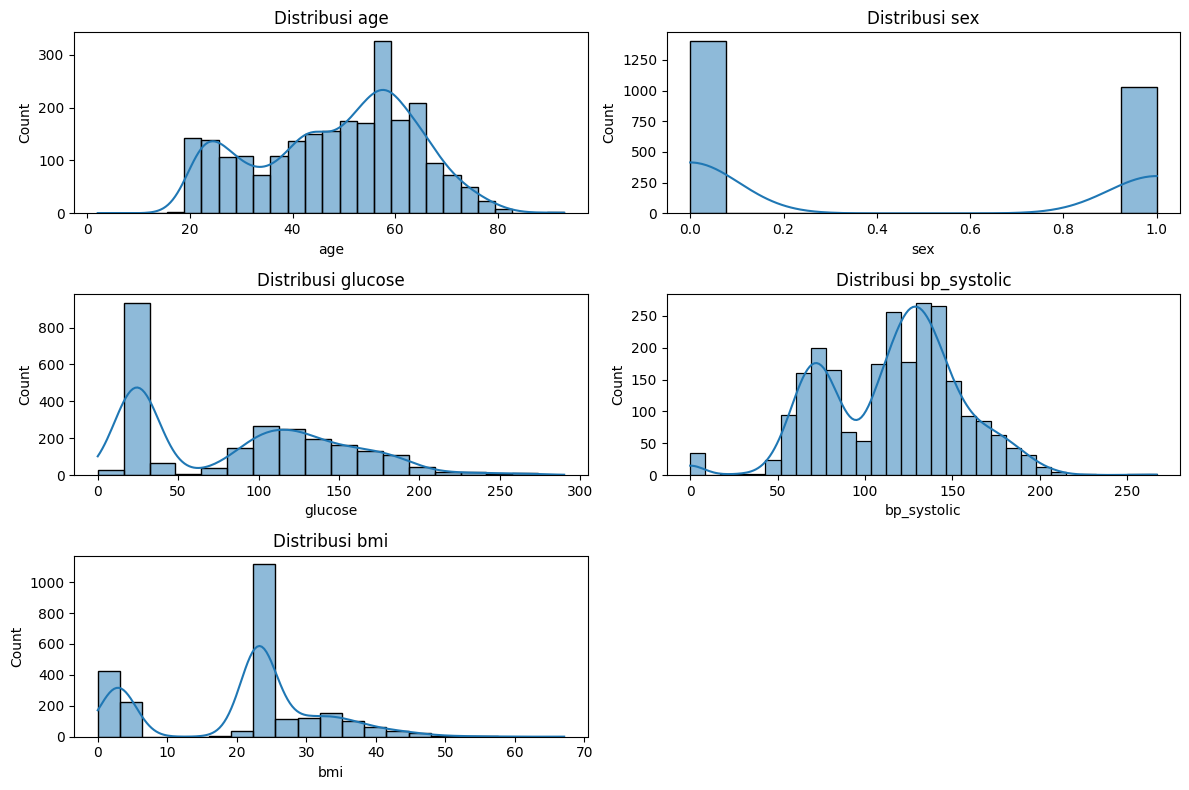

In [11]:
# --- Analisis Empiris ---
print("\n=== Analisis Empiris ===")
print("\nStatistik Deskriptif:\n", combined_df.describe())

# Visualisasi distribusi fitur
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'sex','glucose', 'bp_systolic', 'bmi'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(combined_df[col], kde=True)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

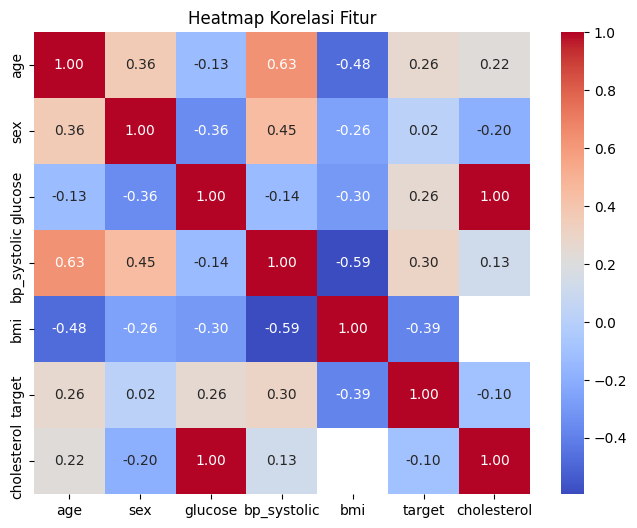

In [12]:
# Heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur')
plt.show()

In [13]:
# Pisahkan fitur dan target
X = combined_df[['age', 'sex', 'glucose', 'bp_systolic', 'bmi']]
y = combined_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Standarisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== Analisis PCA ===
Explained Variance Ratio: [0.48704608 0.26917715]
Total Explained Variance: 0.76

Kontribusi Fitur terhadap Komponen Utama:
                   PC1       PC2
age          0.520306  0.024006
sex          0.423075 -0.389040
glucose     -0.109909  0.788735
bp_systolic  0.568188  0.032938
bmi         -0.464081 -0.474220


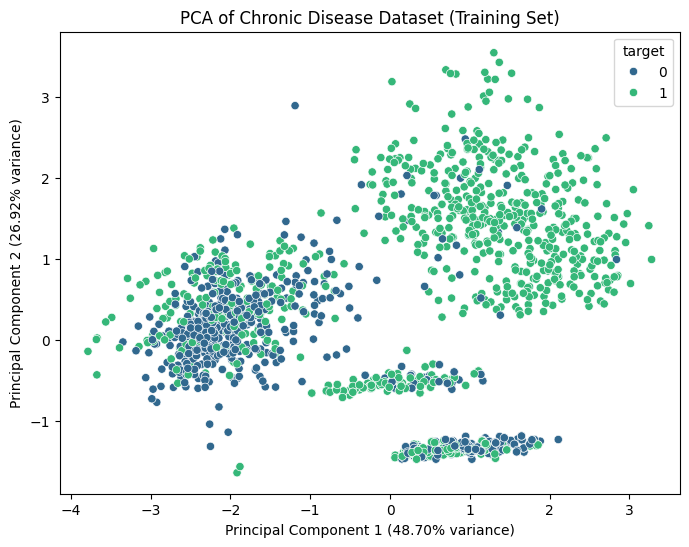

In [16]:
# --- PCA ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"\n=== Analisis PCA ===")
print(f"Explained Variance Ratio: {explained_variance}")
print(f"Total Explained Variance: {sum(explained_variance):.2f}")

# PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X.columns)
print("\nKontribusi Fitur terhadap Komponen Utama:\n", loadings)

# Visualisasi PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis')
plt.title('PCA of Chronic Disease Dataset (Training Set)')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
plt.show()

In [17]:
# --- Hyperparameter Tuning KNN ---
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\n=== Hasil Grid Search KNN ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")


=== Hasil Grid Search KNN ===
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Best Cross-Validation Score: 0.90


In [18]:
# Latih model dengan parameter terbaik
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== KNN pada Fitur Asli (Optimal) ===")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


=== KNN pada Fitur Asli (Optimal) ===
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       205
           1       0.94      0.90      0.92       282

    accuracy                           0.91       487
   macro avg       0.90      0.91      0.90       487
weighted avg       0.91      0.91      0.91       487



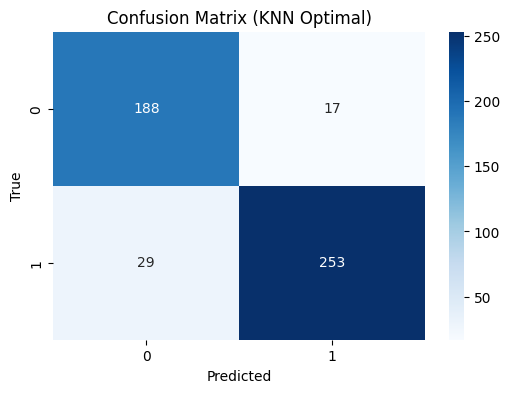

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (KNN Optimal)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Validasi silang
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=5)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")


Cross-Validation Scores: [0.88717949 0.92030848 0.89717224 0.90488432 0.90488432]
Mean CV Accuracy: 0.90 (±0.01)


In [21]:
#--- Kesimpulan ---
print("\n=== Kesimpulan ===")
print("Analisis empiris menunjukkan distribusi fitur dan korelasi antar variabel.")
print(f"PCA menjelaskan {sum(explained_variance):.2%} varians dengan 2 komponen.")
print(f"KNN pada fitur asli dengan parameter optimal mencapai akurasi {accuracy:.2f}.")
print(f"Validasi silang menunjukkan performa model yang konsisten dengan akurasi rata-rata {cv_scores.mean():.2f}.")
print("Fitur tambahan (bmi) dan tuning parameter meningkatkan performa model.")


=== Kesimpulan ===
Analisis empiris menunjukkan distribusi fitur dan korelasi antar variabel.
PCA menjelaskan 75.62% varians dengan 2 komponen.
KNN pada fitur asli dengan parameter optimal mencapai akurasi 0.91.
Validasi silang menunjukkan performa model yang konsisten dengan akurasi rata-rata 0.90.
Fitur tambahan (bmi) dan tuning parameter meningkatkan performa model.
